# Transfer learning - garbage classification

### Import and Inspect Data

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("drive/MyDrive/garbage.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os 

for dirpath,dirname,filenames in os.walk("garbage"):
  print(dirpath,len(dirname),len(filenames))

garbage 2 1
garbage/test 4 1
garbage/test/metal 0 34
garbage/test/glass 0 13
garbage/test/cardboard 0 12
garbage/test/trash 0 6
garbage/train 4 1
garbage/train/metal 0 376
garbage/train/glass 0 488
garbage/train/cardboard 0 391
garbage/train/trash 0 131


### Image Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

#preprocess data
train_datagen = IDG(rescale=1./224,
                    rotation_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

valid_datagen = IDG(rescale=1./224)

#paths
train_dir = "garbage/train"
test_dir = "garbage/test"

#import data and turn to batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               seed=42)

Found 1386 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


### setting up callbacks

e.g:
* tracking experiments via TensorBoard
* Model checkpoint 
* Stopping model before overfitting

In [ ]:
#tensorboard
import datetime
import tensorflow as tf

def tensorboard_callback(dir_name, exp_name):
  log_dir = f"{dir_name}/{exp_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
  callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard to: {log_dir}")
  return callback

### using tensorflow hub

In [ ]:
import tensorflow_hub as hub

def create_model(url,num_classes=4):
  
  """
  uses tfhub url to create uncompiled sequential model
  url -> feature extraction url
  """

  extractor_layer = hub.KerasLayer(url,
                                   trainable=False,
                                   name="feature_extraction_layer",
                                   input_shape=(224,224,3))
    
  model = tf.keras.Sequential([
      extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

effnet = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

### ResNet model

In [ ]:
resnet_model = create_model(resnet)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 4008      
                                                                 
Total params: 25,616,209
Trainable params: 4,008
Non-trainable params: 25,612,201
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_tfboard = tensorboard_callback("tensorflow_hub","resnet50V2")
resnet_history = resnet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data),
                    callbacks=[resnet_tfboard]
                    )

saving tensorboard to: tensorflow_hub/resnet50V2/20221026-111537
Epoch 1/5
44/44 [==============================] - 40s 589ms/step - loss: 1.3715 - accuracy: 0.3903 - val_loss: 1.3561 - val_accuracy: 0.5231
Epoch 2/5
44/44 [==============================] - 19s 421ms/step - loss: 1.3378 - accuracy: 0.6551 - val_loss: 1.3304 - val_accuracy: 0.4923
Epoch 3/5
44/44 [==============================] - 18s 409ms/step - loss: 1.3061 - accuracy: 0.6732 - val_loss: 1.3056 - val_accuracy: 0.4769
Epoch 4/5
44/44 [==============================] - 18s 409ms/step - loss: 1.2761 - accuracy: 0.6717 - val_loss: 1.2819 - val_accuracy: 0.4769
Epoch 5/5
44/44 [==============================] - 18s 408ms/step - loss: 1.2482 - accuracy: 0.6797 - val_loss: 1.2590 - val_accuracy: 0.5077


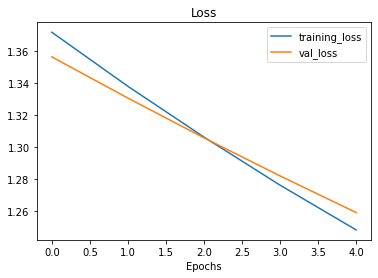

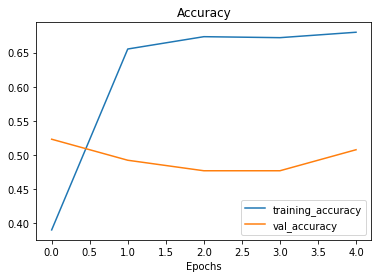

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(resnet_history)

In [ ]:
import pathlib 
import numpy as np

data_dir = pathlib.Path("garbage/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))[1:]
class_names

array(['cardboard', 'glass', 'metal', 'trash'], dtype='<U9')

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)
  pred_class = class_names[max([i for i in range(len(pred[0]))], key=lambda i:pred[0][i])] #could by multiclass or binary
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);



1/1 [==============================] - 0s 32ms/step
[[0.22230278 0.3254038  0.2760244  0.17626895]]


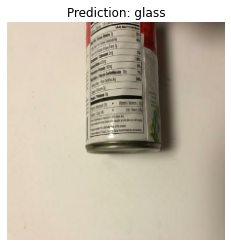

In [ ]:
pred_and_plot(resnet_model,"/content/garbage/test/metal/metal395.jpg",class_names)

In [ ]:
resnet_model.save("garbage-classification-model")

In [ ]:
!zip -r garbage-classifcation-model.zip /content/garbage-classification-model

  adding: content/garbage-classification-model/ (stored 0%)
  adding: content/garbage-classification-model/keras_metadata.pb (deflated 81%)
  adding: content/garbage-classification-model/assets/ (stored 0%)
  adding: content/garbage-classification-model/saved_model.pb (deflated 92%)
  adding: content/garbage-classification-model/variables/ (stored 0%)
  adding: content/garbage-classification-model/variables/variables.index (deflated 80%)
  adding: content/garbage-classification-model/variables/variables.data-00000-of-00001 (deflated 7%)


### Detect With Real Photos 

In [ ]:
import cv2
import uuid
import time

In [ ]:
!mkdir {'/content/garbage/test_img'}

mkdir: cannot create directory ‘/content/garbage/test_img’: File exists


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/garbage/test_img/photos.jpg


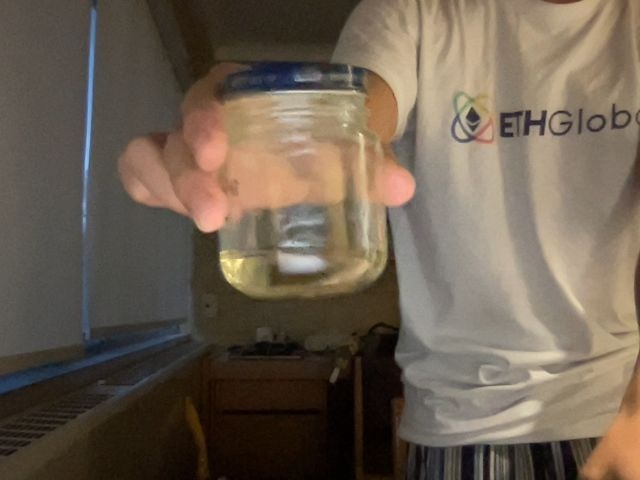

In [ ]:
import uuid #coul

try:
  filename = take_photo('/content/garbage/test_img/photos.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

1/1 [==============================] - 0s 153ms/step
[[0.23199812 0.3417844  0.24233486 0.18388268]]


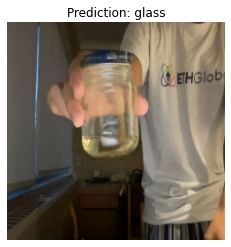

In [ ]:
pred_and_plot(resnet_model,"/content/garbage/test_img/photos.jpg",class_names)